In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
import unittest
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, filename='training.log', filemode='w', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger()


In [2]:
# Cell 2: Load Data
logger.info("Loading data")
train_df = pd.read_csv("train.csv", index_col='id')
test_df = pd.read_csv("test.csv", index_col='id')
logger.info(f"Data loaded successfully. Train shape: {train_df.shape}, Test shape: {test_df.shape}")


In [3]:
# Cell 3: Transform Binary Variables
logger.info("Transforming binary variables")
train_df['Gender'] = train_df['Gender'].map({'Male': 1, 'Female': 0})
train_df['Vehicle_Damage'] = train_df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
logger.info(f"Binary variables transformed. Head of train_df:\n{train_df.head()}")


In [4]:
# Cell 4: Drop Column with Limited Variability
logger.info("Dropping column with limited variability")
train_df = train_df.drop(['Driving_License'], axis=1)
logger.info(f"Column dropped. Head of train_df:\n{train_df.head()}")


In [5]:
# Cell 5: Handle Continuous Variables and Remove Outliers
logger.info("Handling continuous variables and removing outliers")
continuous_numeric = ['Age', 'Vintage', 'Annual_Premium']
Q1 = train_df['Annual_Premium'].quantile(0.25)
Q3 = train_df['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train_df['Outlier_Annual_Premium'] = ((train_df['Annual_Premium'] < lower_bound) | (train_df['Annual_Premium'] > upper_bound)).astype(int)
train_df = train_df[(train_df['Annual_Premium'] >= lower_bound) & (train_df['Annual_Premium'] <= upper_bound)]
train_df = train_df.drop('Outlier_Annual_Premium', axis=1)
logger.info(f"Continuous variables handled and outliers removed. Head of train_df:\n{train_df.head()}")


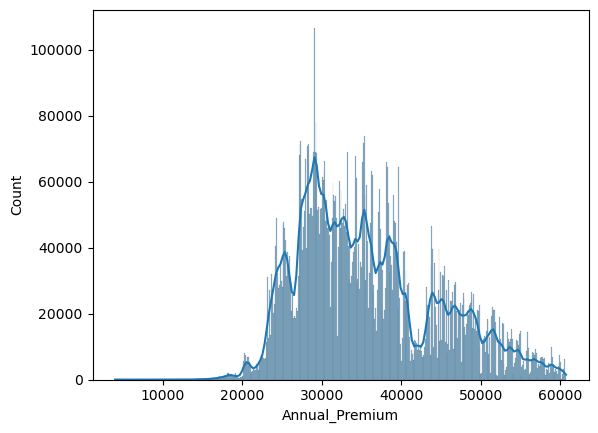

In [6]:
# Cell 6: Verify Distribution After Removing Outliers
logger.info("Verifying distribution after removing outliers")
sns.histplot(train_df['Annual_Premium'], kde=True)
plt.show()
logger.info(f"Distribution verified. Annual_Premium distribution:\n{train_df['Annual_Premium'].describe()}")


In [7]:
# Cell 7: Group Rare Categories
logger.info("Grouping rare categories")
def group_rare_categories(df, column, threshold=0.01):
    category_freq = df[column].value_counts(normalize=True)
    rare_categories = category_freq[category_freq < threshold].index
    df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)
    return df

categorical = ['Region_Code', 'Policy_Sales_Channel']
for column in categorical:
    train_df = group_rare_categories(train_df, column)
logger.info(f"Rare categories grouped. Head of train_df:\n{train_df.head()}")


In [8]:
# Cell 8: Ensure Uniform Data Types for Categorical Features
logger.info("Ensuring uniform data types for categorical features")
categorical_features = ['Vehicle_Age', 'Region_Code', 'Policy_Sales_Channel']
train_df[categorical_features] = train_df[categorical_features].astype(str)
logger.info(f"Uniform data types ensured for categorical features. Data types:\n{train_df.dtypes}")


In [9]:
# Ensure uniform data types for categorical features
categorical_features = ['Vehicle_Age', 'Region_Code', 'Policy_Sales_Channel']
train_df[categorical_features] = train_df[categorical_features].astype(str)

print("Before encoding:")
print(train_df[categorical_features].head())
print(f"Categorical features: {categorical_features}")

# Check unique values in categorical columns to debug
print(f"Unique values in Vehicle_Age: {train_df['Vehicle_Age'].unique()}")
print(f"Unique values in Region_Code: {train_df['Region_Code'].unique()}")
print(f"Unique values in Policy_Sales_Channel: {train_df['Policy_Sales_Channel'].unique()}")

# Apply OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(train_df[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

print(f"Encoded features shape: {encoded_features.shape}")
print(f"Encoded feature names: {encoded_feature_names}")

# Convert to DataFrame
encoded_features_df = pd.DataFrame(encoded_features, index=train_df.index, columns=encoded_feature_names)

# Drop original categorical columns and concatenate encoded features
train_df = train_df.drop(categorical_features, axis=1)
train_df = pd.concat([train_df, encoded_features_df], axis=1)

print("After encoding:")
print(train_df.head())
print(f"Final train_df shape: {train_df.shape}")





Before encoding:
   Vehicle_Age Region_Code Policy_Sales_Channel
id                                             
1    > 2 Years        28.0                 26.0
2     < 1 Year        14.0                152.0
4     1-2 Year        15.0                152.0
5     < 1 Year        47.0                152.0
6     < 1 Year        45.0                152.0
Categorical features: ['Vehicle_Age', 'Region_Code', 'Policy_Sales_Channel']
Unique values in Vehicle_Age: ['> 2 Years' '< 1 Year' '1-2 Year']
Unique values in Region_Code: ['28.0' '14.0' '15.0' '47.0' '45.0' '8.0' '3.0' 'Other' '37.0' '50.0'
 '30.0' '46.0' '29.0' '11.0' '35.0' '10.0' '41.0' '36.0' '33.0' '2.0'
 '18.0' '6.0' '21.0']
Unique values in Policy_Sales_Channel: ['26.0' '152.0' '160.0' 'Other' '124.0' '122.0' '154.0']
Encoded features shape: (9127525, 30)
Encoded feature names: ['Vehicle_Age_< 1 Year' 'Vehicle_Age_> 2 Years' 'Region_Code_11.0'
 'Region_Code_14.0' 'Region_Code_15.0' 'Region_Code_18.0'
 'Region_Code_2.0' 'Region_Cod

In [10]:
import pandas as pd

# Assuming df_transformed is your transformed DataFrame
# Save the DataFrame to a CSV file
train_df.to_csv('transformed__train_dataframe.csv', index=False)


In [10]:
# Cell 10: Prepare Datasets
logger.info("Preparing datasets")
X = train_df.drop('Response', axis=1).values
y = train_df['Response'].values
logger.info(f"Datasets prepared. X shape: {X.shape}, y shape: {y.shape}")


In [11]:
# Cell 11: Split the Data Before Scaling to Prevent Data Leakage
logger.info("Splitting data before scaling to prevent data leakage")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
logger.info(f"Data split. X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")


In [12]:
# Cell 12: Scale Features and Convert to Tensors
logger.info("Scaling features and converting to tensors")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

tensor_x_train = torch.tensor(X_train, dtype=torch.float32)
tensor_y_train = torch.tensor(y_train, dtype=torch.float32)
tensor_x_val = torch.tensor(X_val, dtype=torch.float32)
tensor_y_val = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
val_dataset = TensorDataset(tensor_x_val, tensor_y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
logger.info(f"Features scaled and converted to tensors. Example tensor_x_train:\n{tensor_x_train[:5]}")


In [13]:
# Define the Model
logger.info("Defining the model")
class InsuranceModel(nn.Module):
    def __init__(self, input_dim):
        super(InsuranceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Remove sigmoid here
        return x

input_dim = X_train.shape[1]
model = InsuranceModel(input_dim)
logger.info(f"Model defined. Model structure:\n{model}")



In [14]:
# Set Up Training and Validation
logger.info("Setting up training and validation")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()

num_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []
logger.info("Training and validation set up completed")



In [15]:
# Cell 15: Define Early Stopping Class
logger.info("Defining early stopping class")
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

early_stopping = EarlyStopping(patience=5, min_delta=0.001)
logger.info("Early stopping class defined")


In [16]:
# Training Loop
logger.info("Starting training loop")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0).float()  # Apply sigmoid threshold
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    accuracy = correct / total
    val_accuracies.append(accuracy)

    logger.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}')
    
    if early_stopping.should_stop(val_loss):
        logger.info("Early stopping")
        break
logger.info("Training loop completed")


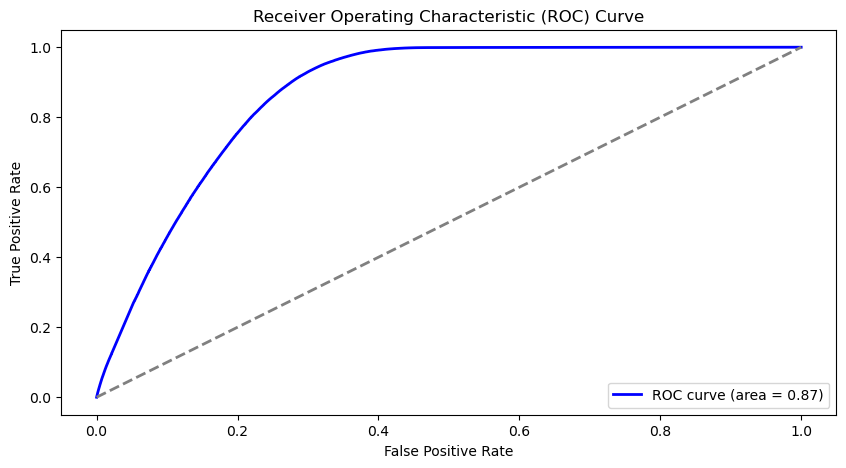

In [17]:
# Cell 17: Calculate ROC AUC Score and Plot ROC Curve
logger.info("Calculating ROC AUC score and plotting ROC curve")
model.eval()
all_labels = []
all_outputs = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

roc_auc = roc_auc_score(all_labels, all_outputs)
fpr, tpr, _ = roc_curve(all_labels, all_outputs)

# Plot ROC Curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

logger.info(f'Validation ROC AUC Score: {roc_auc:.4f}')
